## FINAL DRAFT OF THIS 
Inputs: cdom files 
outputs: wavelenths.csv, plot.png, outputs.csv
    
    the only cells that need edits are at the top 
    they are labled "with edit here"
    
    Hanna Bridgham 
    11/12/2022


In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [2]:
#EDIT HERE
####################################
# This returns a list of names (strings) of files that have the .txt extension. 
# You should provide the path
files = glob.glob('../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB/*.txt')
# You should add the path of your outputs 
path_1 = '../../../BLUE_HOLES/SPECTRA/BC_2226_spectra.csv'
path_2 = '../../../BLUE_HOLES/PLOTS/BC_2226_plot.png'
path_3 = '../../../BLUE_HOLES/OUTPUTS/BC_2226_outputs.csv'
files

['../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222601_Absorbance__0__00.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222601_Absorbance__1__01.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222602_Absorbance__0__02.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222603_Absorbance__0__03.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222604_Absorbance__0__04.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222605_Absorbance__0__05.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222606_Absorbance__0__06.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222607_Absorbance__0__07.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222607_Absorbance__0__08.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222607_Absorbance__1__09.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222607_Absorbance__2__10.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222608_Absorbance__0__11.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_

In [3]:
#EDIT HERE
####################################
#first Identify what wavegide was used then uncomment the correct waveguide 

#WG 50 #1 : 190987 : 48.9
# 50 cm lwcc number 1 SN: , Basiclly antything from GOM2021 thats not PW
#X = .489 

#WG 50 #2 : 190991 : 48.75
#50 cm lwcc number 2 SN: , Basiclly antything from GOM21FA thats not PW
#X = .4875

#WG 50 #3 : 192856 : 48.8 
# 50 cm lwcc number 3 SN: , Basiclly antything from GOM22SP or GOM22SU thats not PW
X = .488

#WG 10 CM 182380 
#X = .10

#WG 5 CM  
#X = .05 

#WG 1 CM  
#X = .01


PART 1: GRAPHS AND WAVELENGTHS 

we use pchip to process the data to get the wavelenths in whole numbers 

we will save this to a output tabel 

we will also save the baseline correction 

In [4]:
#FINAL FUNTION 
#see above for the breakdown of diff parts 
def GET_CDOM_DATA(name):
    df = pd.read_csv(name, skiprows=16, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']*(2.303/X)
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    #xi = np.arange(189,523,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [5]:
#EDIT HERE
n = 10 # how many underscore breaks 
stri = 0 # the selected underscore break 
split = 1 #spit in the file name string 

####################################
#MAKE IT ALL IN ONE EASY TO USE DATA FRAME 
#this makes a new data frame there all the columns are the scanns and the rows are the wavelths 
#edit the slpit function to get the abs names 
frames = []
for f in files:
    df = GET_CDOM_DATA(f) # runs the processing function 
    ID = f.split("\\")[split] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 

#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH
#this filters eveything by all that have the work 'Absorbance' with anything after it 
#and turns it into a new object 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 

#edit here to make the names a 6 diget number code 
names = d.columns.str.rsplit('_', n=n).str[stri]

#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df

,222601,222602,222603,222604,222605,222606,222607,222608,222609,222610,222611,222612,222613,222614,222615,222616,222617,222618
wl,,,,,,,,,,,,,,,,,,
189,24.952242,0.000000,0.000000,20.732775,-70.860138,-89.434743,25.766312,0.000000,0.000000,-46.933038,0.000000,-36.807308,1.915654,-16.240662,3.782677,13.810843,5.374222,-32.505343
190,0.179541,0.000000,0.000000,-4.775967,-7.090804,-8.266930,0.486597,0.000000,0.000000,-0.893217,0.000000,-0.293662,-0.441287,-0.396591,0.071436,2.859531,-0.909305,-3.374196
191,-0.795036,0.000000,0.000000,0.000000,-2.626152,-3.237986,-0.086345,0.000000,0.000000,-2.586899,-1.743243,-4.171799,-1.272784,-0.422596,0.015549,1.091040,-5.504147,-6.130444
192,-1.719970,0.649543,-5.605313,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.443731,0.000000,0.662637,0.094438,-0.360383,0.612337,-0.519869,0.000000
193,-2.046533,0.385857,0.000000,-0.421353,-0.602811,-0.737553,-0.994587,-2.666456,-3.422510,2.672758,0.568182,0.966235,-0.916058,-0.018739,0.081182,1.181955,0.256154,-0.459567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,0.284446,0.165187,1.363944,0.388430,1.046139,1.372585,0.116998,0.493607,0.956460,0.381992,0.326046,0.356622,0.283348,0.138615,0.241665,0.474531,-0.012862,0.171954
877,0.116792,0.420645,1.080102,0.547478,0.756692,1.703318,0.225502,0.568640,0.951268,0.272092,0.328950,0.525677,0.148345,0.204604,0.313365,0.473657,-0.058404,0.030483
878,0.106921,0.311914,1.136897,0.319051,1.346101,1.960400,0.251953,0.609822,0.928801,0.357045,0.487260,0.784820,0.124628,0.230104,0.203997,0.440142,-0.074347,0.208911


,222601,222602,222603,222604,222605,222606,222607,222608,222609,222610,222611,222612,222613,222614,222615,222616,222617,222618
wl,,,,,,,,,,,,,,,,,,
700,0.010456,0.004415,0.013650,0.018530,0.018506,0.020530,0.021939,0.034132,0.032552,0.019435,0.017271,0.029359,0.023860,0.017495,0.029250,0.021747,0.012863,0.016782
701,0.018444,0.012646,0.017236,0.028280,0.025585,0.027130,0.024014,0.033229,0.032450,0.030419,0.025617,0.035049,0.033581,0.024647,0.035622,0.028269,0.023192,0.024208
702,0.019324,0.012096,0.013429,0.026280,0.018273,0.020872,0.027915,0.031209,0.031215,0.028478,0.021683,0.029873,0.039871,0.030052,0.037675,0.032595,0.016792,0.013192
703,0.010924,-0.003601,-0.001773,0.014084,0.007100,0.010914,0.020654,0.022552,0.024161,0.020254,0.010421,0.016215,0.032633,0.019486,0.026204,0.023550,0.006805,0.002813
704,0.003031,-0.007176,-0.003543,0.009400,-0.001787,0.001180,0.009242,0.011436,0.012509,0.005986,-0.001317,0.007258,0.017479,0.009158,0.016960,0.012262,0.000346,-0.001840
705,-0.001136,-0.014640,-0.000511,0.004828,0.000569,0.000670,0.001713,0.011985,0.008133,0.002948,-0.000326,0.010584,0.016665,0.007916,0.016211,0.012317,-0.001525,-0.000970
706,0.001016,-0.010842,0.005844,0.013567,0.010845,0.015999,0.004871,0.018268,0.015721,0.013370,0.010733,0.021731,0.009658,0.003719,0.017913,0.009776,0.001591,0.007175
707,0.014113,0.000666,0.009711,0.015837,0.016473,0.016559,0.015241,0.023793,0.023422,0.019444,0.017250,0.026354,0.019045,0.012502,0.023158,0.016210,0.006370,0.011257
708,0.019226,0.007761,0.015328,0.025835,0.021222,0.023023,0.023593,0.030416,0.029822,0.025678,0.020369,0.028813,0.029224,0.020211,0.029230,0.024200,0.015180,0.017259


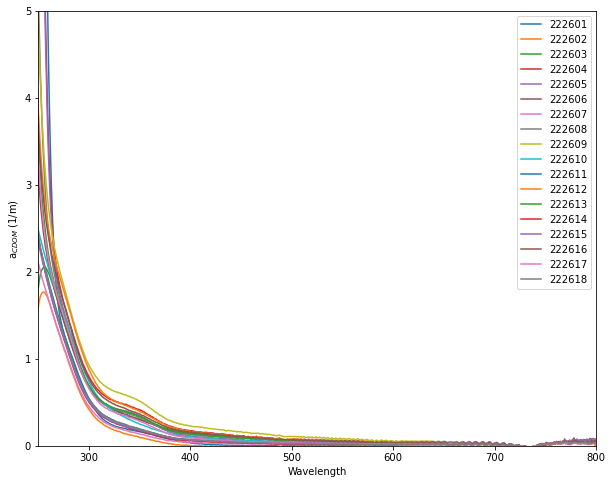

In [6]:
#HERE WE DO THE BASLINE CORRECTION AND SAVE THE CORECTION AS 'bcorr'
bcorr = df[511:562].mean(axis=0) # 486:537 is 675 to 725 nm and this line takes the average 
df = df[:] - bcorr # here we correct the data by that average
#bcorr2 = df[211:412].min(axis=0) # 486:537 is 675 to 725 nm and this line takes the average 
#df = df[:] - bcorr2 # here we correct the data by that average
#bcorr = bcorr1 + bcorr2
bcorr

#HERE WE PULL USEFULL ABS VALUES 
abs_254_data = df[65:66].mean(axis=0)
abs_280_data = df[91:92].mean(axis=0)
abs_320_data = df[131:132].mean(axis=0)
abs_350_data = df[161:162].mean(axis=0)
abs_412_data = df[223:224].mean(axis=0)
abs_440_data = df[251:252].mean(axis=0)

#HERE WE MAKE A COPY OF THE DATA THAT IS VERTICAL SO JB LIKES IT
Abs_data = df.transpose(copy=False)
Abs_data

#save it as a CSV to the propor location with the correct file name
Abs_data.to_csv(path_1)

#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 

fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(0,5)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")

plt.savefig(path_2)
df[511:562]

PART 2: REGRESSIONS

I need an output table for each sampling event with the sample number

we will get this with 2 regression methods 

there are two ways we are going to calculate the spectral slopes 
1. Single exponential (SEM) where: $A(g)=Ae^{slope}$
2. Hyperbolic (HM) where: $A(g)=A(\frac{wl}{532})^{slope}$

corresponding parameters = abs 254, abs 280, abs 320, abs 412, abs 444 

corresponding parameters = the spectral slope of 275 to 295, the spectral slope of 350 to 400, the spectral slope of 275 to 700

corresponding parameters = spectral ratio of spectral slope of 275 to 295 and the spectral slope of 350 to 400

corresponding parameters = baseline correction we used, so the b term 


In [7]:
#OPEN OUR FILES AND MAKE ABSORBANCE TO ABSORPTION
def open_file_abs_base_cor(name):
    df = pd.read_csv(name, skiprows=15, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']*(2.303/X)
    return df

In [8]:
#MAKE IT ALL IN ONE EASY TO USE DATA FRAME 
#this makes a new data frame there all the columns are the scanns and the rows are the wavelths 
frames = []
for f in files:
    df = open_file_abs_base_cor(f) # runs the processing function 
    ID = f.split("\\")[split] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 

#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
names = d.columns.str.rsplit('_', n=n).str[stri]

#names = d.columns.str.rsplit('_', n=6).str[0]
#names = d.columns.str.rsplit('ID', n=2).str[1]
#names = names.str.rsplit('_', n=6).str[0]

#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df['wl'] = df.index

df

,222601,222602,222603,222604,222605,222606,222607,222608,222609,222610,222611,222612,222613,222614,222615,222616,222617,222618,wl
wl,,,,,,,,,,,,,,,,,,,
189.6618,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982,189.6618
190.0441,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982,190.0441
190.4264,-2.412959,0.000000,0.000000,0.000000,0.000000,0.000000,-1.994124,0.000000,0.000000,0.524625,0.000000,0.792521,0.000000,1.284819,-0.292752,0.000000,-1.725520,0.000000,190.4264
190.8087,-0.865277,0.000000,0.000000,0.000000,-5.260562,-6.486154,-0.172961,0.000000,0.000000,-2.281921,-1.262560,-4.727128,0.000000,0.741553,0.031147,1.357260,-1.442207,-1.849322,190.8087
191.1909,-0.642292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.746611,-2.115488,-3.280202,-3.099297,-1.769173,0.000000,0.735182,-9.199415,-9.703747,191.1909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880.5978,0.383440,-0.124117,1.067497,0.315247,0.583301,1.567267,0.141696,0.367631,1.064036,0.305336,0.320753,0.449431,0.423003,0.326652,0.318708,0.536737,0.009439,0.344978,880.5978
880.8884,0.184051,0.271358,1.049564,0.617751,1.164714,1.752734,-0.145471,0.151331,0.700968,0.456353,0.248548,0.588020,0.296370,0.341203,0.382260,0.632774,0.333966,0.289605,880.8884
881.1790,0.260503,0.249649,1.233143,0.506377,0.956123,2.118005,0.150309,0.496938,1.200738,0.549794,0.459971,0.616178,0.371878,0.278358,0.344034,0.555850,-0.155578,0.143623,881.1790


In [9]:
#EXPONENTAL REGRESSION A(g)=Ae^slope
def exp_equation(x, a, s, b):
    return a * np.exp(-s * x) + b

In [10]:
#HERE DO THE WHOLE EXPO AS A LOOP FOR ALL SAMPLES 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #get the x and y values for all the slope intervals we want 
    ydata_s700 = df[(df['wl']>=275) & (df['wl']<=700)][col]
    xdata_s700 = df[(df['wl']>=275) & (df['wl']<=700)]['wl']
    ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
    xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
    ydata_s295 = df[(df['wl']>=275) & (df['wl']<=295)][col]
    xdata_s295 = df[(df['wl']>=275) & (df['wl']<=295)]['wl']
    ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
    xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
    ydata_s350 = df[(df['wl']>=350) & (df['wl']<=400)][col]
    xdata_s350 = df[(df['wl']>=350) & (df['wl']<=400)]['wl']
    ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
    xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams_700 = (15, .001, 0)
    pams_295 = (10, .001, 0)
    pams_350 = (10, .001, 0)
    
    #regression exp_equation 275 to 700
    params, cv = curve_fit(exp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 275 to 700 and calcuate rSquared
    squaredDiffs = np.square(ydata_s700 - exp_equation(xdata_s700, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_700 = rSquared
    ss_275_700 = s
    
    #get the waveleths we need
    abs_254 = exp_equation(252, a, s, b)
    abs_280 = exp_equation(280, a, s, b)
    abs_320 = exp_equation(320, a, s, b)
    abs_350 = exp_equation(350, a, s, b)
    abs_412 = exp_equation(412, a, s, b)
    abs_440 = exp_equation(440, a, s, b)
    
    #regression exp_equation 275 to 295
    params, cv = curve_fit(exp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 270 to 295 and calcuate rSquared
    squaredDiffs = np.square(ydata_s295 - exp_equation(xdata_s295, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_295 = rSquared
    ss_275_295 = s
    
    #regression exp_equation 350 to 400
    params, cv = curve_fit(exp_equation, xdata_s350, ydata_s350, p0=pams_350, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 350 to 400 and calcuate rSquared
    squaredDiffs = np.square(ydata_s350 - exp_equation(xdata_s350, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_350_400 = rSquared
    ss_350_400 = s 
    
    #get the spectral ratio 
    sr = ss_275_295 / ss_350_400
    
    dict = {'sample':[columnName],
        'ss_275_700_SEM':[ss_275_700],
        'ss_275_295_SEM':[ss_275_295],
        'ss_350_400_SEM':[ss_350_400],
        'R2_275_700':[R2_275_700],
        'R2_275_295':[R2_275_295],
        'R2_350_400':[R2_350_400],
        'SR_SEM':[sr],
        'abs_254_SEM':[abs_254], 
        'abs_280_SEM':[abs_280],
        'abs_320_SEM':[abs_320], 
        'abs_350_SEM':[abs_350],
        'abs_412_SEM':[abs_412], 
        'abs_440_SEM':[abs_440]}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

ss_outs

,ss_275_700_SEM,ss_275_295_SEM,ss_350_400_SEM,R2_275_700,R2_275_295,R2_350_400,SR_SEM,abs_254_SEM,abs_280_SEM,abs_320_SEM,abs_350_SEM,abs_412_SEM,abs_440_SEM
sample,,,,,,,,,,,,,
222601,0.033934,0.010068,0.010055,0.992431,0.999764,0.996524,1.001282,2.808498,1.060157,0.241532,0.060361,-0.029627,-0.037294
222602,0.036977,0.018067,0.028121,0.995393,0.999540,0.989926,0.642471,2.658364,0.943303,0.214104,0.069890,0.006095,0.001472
222603,0.022858,0.021325,0.022604,0.983594,0.999652,0.995448,0.943440,2.249979,1.236006,0.558299,0.333338,0.160354,0.134191
222604,0.021042,0.013774,0.028720,0.983188,0.999666,0.995362,0.479593,2.483500,1.446532,0.711282,0.450615,0.234757,0.198982
222605,0.024116,0.012150,0.032124,0.981284,0.999671,0.994339,0.378223,2.467542,1.284629,0.525606,0.284907,0.109005,0.084045
222606,0.023556,0.018609,0.026317,0.983684,0.999763,0.995793,0.707085,2.229893,1.182376,0.497933,0.276426,0.110850,0.086678
222607,0.035048,0.019662,0.030078,0.995571,0.999702,0.993584,0.653714,2.478950,0.930268,0.230343,0.081684,0.010926,0.005244
222608,0.025308,0.014741,0.029815,0.985741,0.999744,0.995834,0.494412,2.467695,1.221641,0.452369,0.218784,0.056073,0.034348
222609,0.019013,0.015860,0.028075,0.982875,0.999738,0.995796,0.564923,2.508197,1.504575,0.744197,0.454098,0.192895,0.144984


In [11]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

R_level = .95 #set x to the r2 value you want to test

min_1 = ss_outs['R2_275_700'].min()
min_2 = ss_outs['R2_275_295'].min()
min_3 = ss_outs['R2_350_400'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
if min_2 < R_level:
    print("!!! WARNING !!! 275_295 has a bad R2 !!!")
if min_3 < R_level:
    print("!!! WARNING !!! 350_400 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")
    
ss_outs.loc[ss_outs.R2_275_700 < R_level, 'ss_275_700_SEM'] = np.nan
ss_outs.loc[ss_outs.R2_275_295 < R_level, 'ss_275_295_SEM'] = np.nan
ss_outs.loc[ss_outs.R2_350_400 < R_level, 'ss_350_400_SEM'] = np.nan
    
#HERE WE SAME THE SLOPE VALUES 
ss_275_700_SEM = ss_outs['ss_275_700_SEM']
ss_275_295_SEM = ss_outs['ss_275_295_SEM']
ss_350_400_SEM = ss_outs['ss_350_400_SEM']
abs_254_SEM = ss_outs['abs_254_SEM']
abs_280_SEM = ss_outs['abs_280_SEM']
abs_320_SEM = ss_outs['abs_320_SEM']
abs_412_SEM = ss_outs['abs_412_SEM']
abs_440_SEM = ss_outs['abs_440_SEM']
SR_SEM = ss_outs['SR_SEM']

THE FITS ARE GOOD, YAY!


In [12]:
#HYPERBOLIC REGRESSION A(g)=A(wl/532)^slope
def hyp_equation(x, a, s, b):
    return a * ((x/532)**-s) + b

In [13]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #get the x and y values for all the slope intervals we want 
    #get the x and y values for all the slope intervals we want 
    ydata_s700 = df[(df['wl']>=275) & (df['wl']<=700)][col]
    xdata_s700 = df[(df['wl']>=275) & (df['wl']<=700)]['wl']
    ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
    xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
    ydata_s295 = df[(df['wl']>=275) & (df['wl']<=295)][col]
    xdata_s295 = df[(df['wl']>=275) & (df['wl']<=295)]['wl']
    ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
    xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
    ydata_s350 = df[(df['wl']>=350) & (df['wl']<=400)][col]
    xdata_s350 = df[(df['wl']>=350) & (df['wl']<=400)]['wl']
    ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
    xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams_700 = (.001, 11, 0)
    pams_295 = (1, 0, 1)
    pams_350 = (1, 1, 1)
    
    maxfev = 1000000
    
    #regression exp_equation 275 to 700
    params, cv = curve_fit(hyp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 275 to 700 and calcuate rSquared
    squaredDiffs = np.square(ydata_s700 - hyp_equation(xdata_s700, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_700 = rSquared
    ss_275_700 = s
    
    #get the waveleths we need
    abs_254 = hyp_equation(252, a, s, b)
    abs_280 = hyp_equation(280, a, s, b)
    abs_320 = hyp_equation(320, a, s, b)
    abs_350 = hyp_equation(350, a, s, b)
    abs_412 = hyp_equation(412, a, s, b)
    abs_440 = hyp_equation(440, a, s, b)
    
    #regression exp_equation 275 to 295
    params, cv = curve_fit(hyp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 270 to 295 and calcuate rSquared
    squaredDiffs = np.square(ydata_s295 - hyp_equation(xdata_s295, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_295 = rSquared
    ss_275_295 = s
    
    #regression exp_equation 350 to 400
    params, cv = curve_fit(hyp_equation, xdata_s350, ydata_s350, p0=pams_350, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 350 to 400 and calcuate rSquared
    squaredDiffs = np.square(ydata_s350 - hyp_equation(xdata_s350, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_350_400 = rSquared
    ss_350_400 = s 
    
    #get the spectral ratio 
    sr = ss_275_295 / ss_350_400
    
    dict = {'sample':[columnName],
        'ss_275_700_HM':[ss_275_700],
        'ss_275_295_HM':[ss_275_295],
        'ss_350_400_HM':[ss_350_400],
        'R2_275_700':[R2_275_700],
        'R2_275_295':[R2_275_295],
        'R2_350_400':[R2_350_400],
        'SR_HM':[sr],
        'abs_254_HM':[abs_254], 
        'abs_280_HM':[abs_280],
        'abs_320_HM':[abs_320], 
        'abs_350_HM':[abs_350],
        'abs_412_HM':[abs_412], 
        'abs_440_HM':[abs_440]}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

In [14]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

R_level = .95 #set x to the r2 value you want to test

min_1 = ss_outs['R2_275_700'].min()
min_2 = ss_outs['R2_275_295'].min()
min_3 = ss_outs['R2_350_400'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
if min_2 < R_level:
    print("!!! WARNING !!! 275_295 has a bad R2 !!!")
if min_3 < R_level:
    print("!!! WARNING !!! 350_400 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")

ss_outs.loc[ss_outs.R2_275_700 < R_level, 'ss_275_700_HM'] = np.nan
ss_outs.loc[ss_outs.R2_275_295 < R_level, 'ss_275_295_HM'] = np.nan
ss_outs.loc[ss_outs.R2_350_400 < R_level, 'ss_350_400_HM'] = np.nan
    
    
#HERE WE SAME THE SLOPE VALUES 
ss_275_700_HM = ss_outs['ss_275_700_HM']
ss_275_295_HM = ss_outs['ss_275_295_HM']
ss_350_400_HM = ss_outs['ss_350_400_HM']
abs_254_HM = ss_outs['abs_254_HM']
abs_280_HM = ss_outs['abs_280_HM']
abs_320_HM = ss_outs['abs_320_HM']
abs_412_HM = ss_outs['abs_412_HM']
abs_440_HM = ss_outs['abs_440_HM']
SR_HM = ss_outs['SR_HM']

THE FITS ARE GOOD, YAY!


PART 3: MAKE ESTIMATE OF INFLECTION 

So at a lot of these there is an infection at around 350 nm 

We need a way to estimate that inflection 

we are going to look for inflections between 300 and 400 nm and quantify them 


In [15]:
#EXPONENTAL REGRESSION A(g)=Ae^slope
def exp_equation(x, a, s, b):
    return a * np.exp(-s * x) + b

In [16]:
#NORMALIZE THE DATA
#x ′ = ( x − x m i n ) / ( x m a x − x m i n )
df1 = df[(df['wl']>=250) & (df['wl']<=700)]
min1 = df1.min(axis=0)
max1 = df1.max(axis=0)
rang = max1 - min1
rang 
df1 = (df1[:] - min1)/ rang
df1['wl'] = df1.index
df1

,222601,222602,222603,222604,222605,222606,222607,222608,222609,222610,222611,222612,222613,222614,222615,222616,222617,222618,wl
wl,,,,,,,,,,,,,,,,,,,
250.3281,0.989345,0.914165,0.893646,0.993882,0.982262,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,250.3281
250.7040,0.988188,0.929963,0.913004,1.000000,1.000000,0.981346,0.992528,0.961870,0.970795,0.991676,0.990657,0.976157,0.973677,0.986798,0.987921,0.977680,0.982191,0.993278,250.7040
251.0799,0.987515,0.940758,0.922341,0.965116,0.977293,0.959327,0.982963,0.930192,0.941394,0.984306,0.986319,0.956466,0.948468,0.977537,0.979574,0.958819,0.959508,0.980890,251.0799
251.4558,0.991040,0.946551,0.932589,0.978372,0.961265,0.940061,0.971529,0.897681,0.914053,0.978396,0.977443,0.936036,0.927133,0.968604,0.971431,0.940707,0.939189,0.973443,251.4558
251.8316,0.996852,0.961822,0.947165,0.959051,0.937063,0.922171,0.965020,0.863534,0.890735,0.972868,0.969501,0.915564,0.904686,0.955337,0.959826,0.920370,0.920898,0.963558,251.8316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698.6095,0.001318,0.007636,0.005693,0.003059,0.000641,0.003364,0.000000,0.001451,0.001308,0.004511,0.004338,0.006988,0.000000,0.000131,0.000000,0.000154,0.000000,0.000329,698.6095
698.9292,0.001722,0.006319,0.007288,0.003596,0.001443,0.003670,0.000849,0.002007,0.001374,0.006354,0.005339,0.008139,0.001381,0.001478,0.002986,0.001300,0.002606,0.004217,698.9292
699.2488,0.001587,0.011848,0.010020,0.003542,0.001656,0.003976,0.003623,0.003273,0.002257,0.009086,0.008542,0.008592,0.001069,0.001642,0.002511,0.001410,0.002606,0.004152,699.2488


In [17]:
#HERE WE FIND THE INTIGRAL OF ALL THE SAMPLE FOR 350 INFLECTION 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #define where we expect to find the inflection 
    ydata = df1[(df1['wl']>=300) & (df1['wl']<=400)][col]
    xdata = df1[(df1['wl']>=300) & (df1['wl']<=400)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    #here we take evething not in the infelction for the abs data
    ydata_r1 = df1[(df1['wl']>=250) & (df1['wl']<=300)][col]
    ydata_r2 = df1[(df1['wl']>=400) & (df1['wl']<=700)][col]
    ydata_r = pd.concat([ydata_r1, ydata_r2], axis=0)
    
    #here we take evething not in the infelction for the wl data
    xdata_r1 = df1[(df1['wl']>=250) & (df1['wl']<=300)]['wl']
    xdata_r2 = df1[(df1['wl']>=400) & (df1['wl']<=700)]['wl']
    xdata_r = pd.concat([xdata_r1, xdata_r2], axis=0)
    
    #here we make them both arrays so we can doo math 
    ydata_r = np.asarray(ydata_r, dtype=float).ravel()
    xdata_r = np.asarray(xdata_r, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams = (1, .001, 0)
    
    #here we do an expodental fit for just the data where we expect there to de no inflection 
    #aka, what the regression would be without the inflection 
    params, cv = curve_fit(exp_equation, xdata_r, ydata_r, p0=pams, maxfev = maxfev)
    a, s, b = params
    
    #here we calculate the R squared of that regressions fit 
    squaredDiffs = np.square(ydata_r - exp_equation(xdata_r, a, s, b))
    squaredDiffsFromMean = np.square(ydata_r - np.mean(ydata_r))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    
    #here we take the differance of the accual data and the regressions fit that dident have that data 
    diffs = ydata - exp_equation(xdata, a, s, b)
    
    #here we normalize the data 
    diffs = (diffs - np.min(diffs)) / (np.max(diffs) - np.min(diffs))
    
    #here we flaten the data
    y1 = xdata[0]
    y2 = xdata[273]
    x1 = diffs[0]
    x2 = diffs[273]
    m = (x2 - x1)/(y2 - y1)
    mx = m * y1
    b = x1 - mx
    
    diffs = diffs - ((m*xdata)+b)
    
    #here we calculate the intigral 
    inter = scipy.integrate.simps(ydata, x=diffs, even='avg')
    
    #plt.plot(xdata, diffs, 'ko', label='data')
    #plt.plot(xdata, gauss(xdata, *gauss_fit(xdata, diffs)), '--r', label='fit')
    #plt.show()
    #print('The offset of the gaussian baseline is', gaus_baseline)
    #print('The center of the gaussian fit is', center_gaus)
    #print('The sigma of the gaussian fit is', sigma)
    #print('The maximum intensity of the gaussian fit is', H + A)
    #print('The Amplitude of the gaussian fit is', A)
    #print('The FWHM of the gaussian fit is', FWHM)
    
    #here we define some columns for a new data frame with the sample, the R2, and the diffs intigral 
    dict = {'sample':[columnName],
        '350_intergration':[inter],
        'R2':[rSquared]}
    diff = pd.DataFrame(dict)
    
    #here we set the index and append the data together 
    diffs = diff.set_index('sample', drop=True)
    Frames.append(diffs) # adds the new col from each scan to a part of frames 
    
    
diffs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
diffs = diffs.drop('wl') # drops the wl col 
diffs

,350_intergration,R2
sample,,
222601,-0.007089,0.977326
222602,0.016488,0.990311
222603,0.018605,0.990867
222604,-0.000139,0.974642
222605,-0.000602,0.975996
222606,0.045641,0.996613
222607,0.021031,0.997915
222608,0.033611,0.985835
222609,0.058475,0.989789


In [18]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

diffs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
diffs = diffs.drop('wl') # drops the wl col 

R_level = .95 #set x to the r2 value you want to test

min_1 = diffs['R2'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")

diffs.loc[diffs.R2 < R_level, '350_intergration'] = np.nan

THE FITS ARE GOOD, YAY!


In [19]:
#NOW WE SAVE ALL THE VALUSE WE WANTED TO A TABEL 
outputs = pd.concat([ss_275_700_SEM, ss_275_295_SEM, ss_350_400_SEM,
                    ss_275_700_HM, ss_275_295_HM, ss_350_400_HM,
                    abs_254_SEM, abs_280_SEM, abs_320_SEM, abs_412_SEM, abs_440_SEM,
                    abs_254_HM, abs_280_HM, abs_320_HM, abs_412_HM, abs_440_HM,
                    SR_SEM, SR_HM], axis=1)
#outputs = outputs.rename(columns={0: 'baseline_correction', 1: 'abs_254',
#                                  2: 'abs_280', 3: 'abs_320', 4: 'abs_412', 5: 'abs_444'})
outputs['350_intergration'] = diffs['350_intergration']
outputs['bcorr'] = bcorr
outputs['abs_254'] = abs_254_data
outputs['abs_254'] = abs_254_data
outputs['abs_320'] = abs_320_data
outputs['abs_350'] = abs_350_data
outputs['abs_412'] = abs_412_data
outputs['abs_440'] = abs_440_data

#SAVE IT 
outputs.to_csv(path_3)
outputs

,ss_275_700_SEM,ss_275_295_SEM,ss_350_400_SEM,ss_275_700_HM,ss_275_295_HM,ss_350_400_HM,abs_254_SEM,abs_280_SEM,abs_320_SEM,abs_412_SEM,...,abs_440_HM,SR_SEM,SR_HM,350_intergration,bcorr,abs_254,abs_320,abs_350,abs_412,abs_440
sample,,,,,,,,,,,,,,,,,,,,,
222601,0.033934,0.010068,0.010055,10.196137,1.865604,2.733364,2.808498,1.060157,0.241532,-0.029627,...,-0.034584,1.001282,0.682530,-0.007089,-0.052202,8.612879,0.256882,0.162593,0.019974,0.004161
222602,0.036977,0.018067,0.028121,11.081768,4.132872,-0.001300,2.658364,0.943303,0.214104,0.006095,...,0.002958,0.642471,-3180.072814,0.016488,0.002375,1.761226,0.205325,0.096746,-0.002306,-0.011455
222603,0.022858,0.021325,0.022604,7.020416,5.060231,7.395829,2.249979,1.236006,0.558299,0.160354,...,0.143306,0.943440,0.684201,0.018605,0.060443,2.031606,0.446356,0.302937,0.135551,0.110315
222604,0.021042,0.013774,0.028720,6.543705,2.912205,-0.001196,2.483500,1.446532,0.711282,0.234757,...,0.210361,0.479593,-2435.571302,-0.000139,0.102242,7.129655,0.541446,0.415874,0.155790,0.123259
222605,0.024116,0.012150,0.032124,7.453383,2.449785,10.895851,2.467542,1.284629,0.525606,0.109005,...,0.092775,0.378223,0.224837,-0.000602,0.023496,6.880996,0.451262,0.342734,0.102037,0.075104
222606,0.023556,0.018609,0.026317,7.221409,4.288995,8.772564,2.229893,1.182376,0.497933,0.110850,...,0.095254,0.707085,0.488910,0.045641,0.011129,2.573590,0.439719,0.299406,0.134394,0.105572
222607,0.035048,0.019662,0.030078,10.514246,4.586557,-0.001329,2.478950,0.930268,0.230343,0.010926,...,0.007177,0.653714,-3450.873313,0.021031,-0.021150,1.922175,0.241475,0.136290,0.034784,0.028747
222608,0.025308,0.014741,0.029815,7.762005,3.188591,-0.000929,2.467695,1.221641,0.452369,0.056073,...,0.042251,0.494412,-3430.647056,0.033611,-0.040739,3.655314,0.449898,0.320765,0.118668,0.095414
222609,0.019013,0.015860,0.028075,5.946523,3.506351,9.406753,2.508197,1.504575,0.744197,0.192895,...,0.158714,0.564923,0.372748,0.058475,0.007765,3.710315,0.656898,0.514148,0.212958,0.171785


#NOW WE SAVE ALL THE VALUSE WE WANTED TO A TABEL 
outputs = pd.concat([ss_275_700_SEM, ss_275_295_SEM, ss_350_400_SEM,
                    abs_254_SEM, abs_280_SEM, abs_320_SEM, abs_412_SEM, abs_440_SEM,
                    SR_SEM], axis=1)
#outputs = outputs.rename(columns={0: 'baseline_correction', 1: 'abs_254',
#                                  2: 'abs_280', 3: 'abs_320', 4: 'abs_412', 5: 'abs_444'})
outputs['350_intergration'] = diffs['350_intergration']
outputs['bcorr'] = bcorr
outputs['abs_254'] = abs_254_data
outputs['abs_254'] = abs_254_data
outputs['abs_320'] = abs_320_data
outputs['abs_350'] = abs_350_data
outputs['abs_412'] = abs_412_data
outputs['abs_440'] = abs_440_data

outputs 
#SAVE IT 
outputs.to_csv(path_3)
outputs